<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/binary/bert_binary_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://www.tensorflow.org/tutorials/text/classify_text_with_bert


In [1]:
!pip install -U -q tensorflow-text
!pip install -U -q tf-models-official

     |████████████████████████████████| 3.4MB 16.7MB/s 
     |████████████████████████████████| 1.1MB 18.9MB/s 
     |████████████████████████████████| 37.6MB 82kB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 706kB 50.2MB/s 
     |████████████████████████████████| 358kB 58.2MB/s 
     |████████████████████████████████| 645kB 52.5MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 
     |████████████████████████████████| 174kB 61.1MB/s 


In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow_hub import KerasLayer
import tensorflow_text
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 2021
epochs = 100
lr = 3e-5
earlystopping_patience = 4

In [4]:
# Download the IMDB dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir=".", cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

# Training dataset
raw_train_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)
class_names = raw_train_ds.class_names
print("Class names: {}".format(class_names))
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Validation dataset
val_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Tesing dataset
test_ds = text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

84131840/84125825 [==============================] - 4s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Class names: ['neg', 'pos']
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
# Choose a BERT model to fine-tune

map_name_to_handle = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_base/2",
    "electra_small":
        "https://tfhub.dev/google/electra_small/2",
    "electra_base":
        "https://tfhub.dev/google/electra_base/2",
    "experts_pubmed":
        "https://tfhub.dev/google/experts/bert/pubmed/2",
    "experts_wiki_books":
        "https://tfhub.dev/google/experts/bert/wiki_books/2",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1",
}

map_model_to_preprocess = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_preprocess/2",
    "electra_small":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "electra_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_pubmed":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_wiki_books":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
}

bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8" 
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f"BERT model selected: {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["binary_accuracy"]
  val_acc = history_dict["val_binary_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 148s 251ms/step - loss: 0.7557 - binary_accuracy: 0.5284 - val_loss: 0.5404 - val_binary_accuracy: 0.6982
Epoch 2/100
563/563 [==============================] - 140s 249ms/step - loss: 0.5099 - binary_accuracy: 0.7323 - val_loss: 0.4337 - val_binary_accuracy: 0.7986
Epoch 3/100
563/563 [==============================] - 140s 248ms/step - loss: 0.3952 - binary_accuracy: 0.8124 - val_loss: 0.3983 - val_binary_accuracy: 0.8108
Epoch 4/100
563/563 [==============================] - 140s 248ms/step - loss: 0.3516 - binary_accuracy: 0.8364 - val_loss: 0.4004 - val_binary_accuracy: 0.8152
Epoch 5/100
563/563 [==============================] - 139s 247ms/step - loss: 0.2948 - binary_accuracy: 0.8711 - val_loss: 0.3796 - val_binary_accuracy: 0.8354
Epoch 6/100
563/563 [==============================] - 139s 247ms/step - loss: 0.2521 

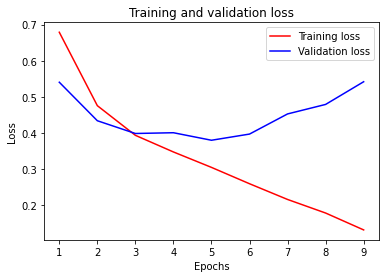

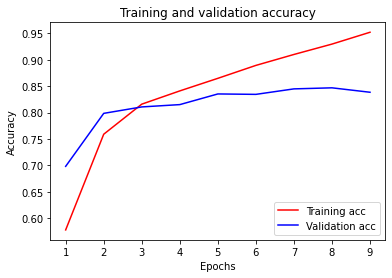

              precision    recall  f1-score   support

           0      0.810     0.896     0.851     12500
           1      0.884     0.790     0.834     12500

    accuracy                          0.843     25000
   macro avg      0.847     0.843     0.843     25000
weighted avg      0.847     0.843     0.843     25000


KFold: 2 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 146s 250ms/step - loss: 0.7887 - binary_accuracy: 0.5464 - val_loss: 0.5103 - val_binary_accuracy: 0.7362
Epoch 2/100
563/563 [==============================] - 141s 250ms/step - loss: 0.4852 - binary_accuracy: 0.7511 - val_loss: 0.4253 - val_binary_accuracy: 0.8010
Epoch 3/100
563/563 [==============================] - 141s 251ms/step - loss: 0.3914 - binary_accuracy: 0.8150 - val_loss: 0.3948 - val_binary_accuracy: 0.8252
Epoch 4/100
563/563 [==============================] - 141s 251ms/step - loss: 0

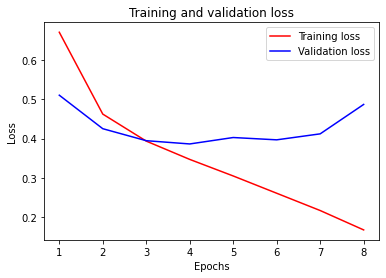

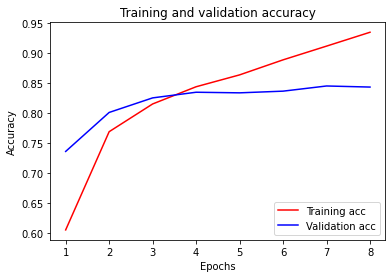

              precision    recall  f1-score   support

           0      0.837     0.852     0.845     12500
           1      0.849     0.835     0.842     12500

    accuracy                          0.843     25000
   macro avg      0.843     0.843     0.843     25000
weighted avg      0.843     0.843     0.843     25000


KFold: 3 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 146s 250ms/step - loss: 0.6875 - binary_accuracy: 0.5385 - val_loss: 0.5434 - val_binary_accuracy: 0.6790
Epoch 2/100
563/563 [==============================] - 140s 249ms/step - loss: 0.5145 - binary_accuracy: 0.7256 - val_loss: 0.4203 - val_binary_accuracy: 0.7916
Epoch 3/100
563/563 [==============================] - 141s 250ms/step - loss: 0.4036 - binary_accuracy: 0.8058 - val_loss: 0.4051 - val_binary_accuracy: 0.8158
Epoch 4/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3563 - binary_accuracy: 0.8353 - val_loss: 0.3879 - val_binary_accuracy: 0.8278
Epoch 5/100
563/563 [==============================] - 141s 250ms/step - loss: 0.3058 - binary_accuracy: 0.8669 - val_loss: 0.3769 - val_binary_accuracy: 0.8326
Epoch 6/100
563/563 [==============================] - 141s 250ms/step - loss: 0.2546 - binary_accuracy

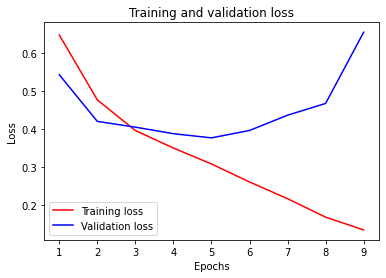

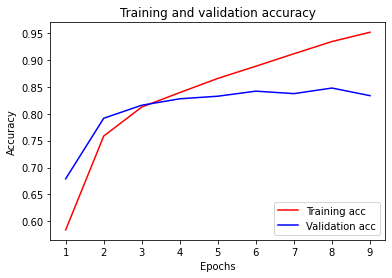

              precision    recall  f1-score   support

           0      0.801     0.902     0.848     12500
           1      0.888     0.776     0.828     12500

    accuracy                          0.839     25000
   macro avg      0.844     0.839     0.838     25000
weighted avg      0.844     0.839     0.838     25000


KFold: 4 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 147s 253ms/step - loss: 0.7389 - binary_accuracy: 0.5204 - val_loss: 0.5471 - val_binary_accuracy: 0.6838
Epoch 2/100
563/563 [==============================] - 142s 252ms/step - loss: 0.5228 - binary_accuracy: 0.7197 - val_loss: 0.4264 - val_binary_accuracy: 0.7938
Epoch 3/100
563/563 [==============================] - 142s 253ms/step - loss: 0.4071 - binary_accuracy: 0.8063 - val_loss: 0.4034 - val_binary_accuracy: 0.8194
Epoch 4/100
563/563 [==============================] - 142s 253ms/step - loss: 0.3441 - binary_accuracy: 0.8443 - val_loss: 0.3839 - val_binary_accuracy: 0.8298
Epoch 5/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2998 - binary_accuracy: 0.8701 - val_loss: 0.3901 - val_binary_accuracy: 0.8246
Epoch 6/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2506 - binary_accuracy

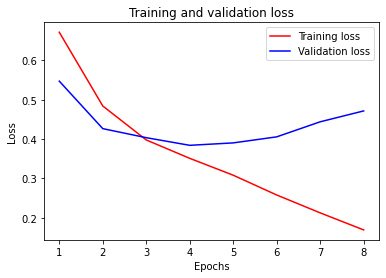

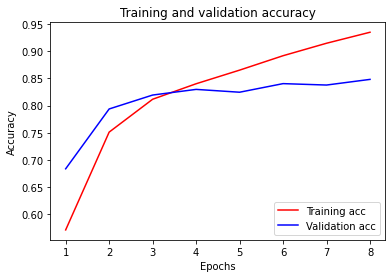

              precision    recall  f1-score   support

           0      0.826     0.862     0.843     12500
           1      0.855     0.818     0.837     12500

    accuracy                          0.840     25000
   macro avg      0.841     0.840     0.840     25000
weighted avg      0.841     0.840     0.840     25000


KFold: 5 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 149s 254ms/step - loss: 0.6967 - binary_accuracy: 0.5426 - val_loss: 0.5221 - val_binary_accuracy: 0.7360
Epoch 2/100
563/563 [==============================] - 143s 254ms/step - loss: 0.5025 - binary_accuracy: 0.7382 - val_loss: 0.4270 - val_binary_accuracy: 0.7898
Epoch 3/100
563/563 [==============================] - 142s 253ms/step - loss: 0.3956 - binary_accuracy: 0.8114 - val_loss: 0.4093 - val_binary_accuracy: 0.8230
Epoch 4/100
563/563 [==============================] - 144s 255ms/step - loss: 0.3452 - binary_accuracy: 0.8392 - val_loss: 0.4227 - val_binary_accuracy: 0.8248
Epoch 5/100
563/563 [==============================] - 143s 253ms/step - loss: 0.2993 - binary_accuracy: 0.8671 - val_loss: 0.3729 - val_binary_accuracy: 0.8392
Epoch 6/100
563/563 [==============================] - 143s 253ms/step - loss: 0.2631 - binary_accuracy

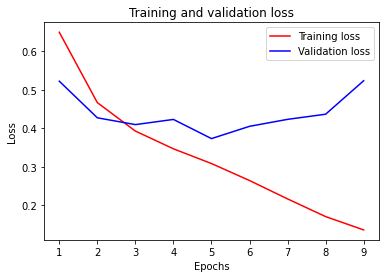

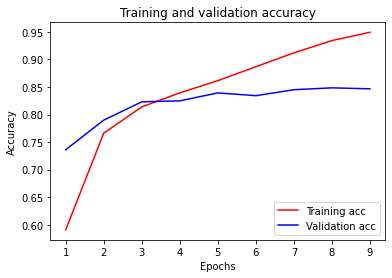

              precision    recall  f1-score   support

           0      0.830     0.877     0.853     12500
           1      0.870     0.820     0.844     12500

    accuracy                          0.849     25000
   macro avg      0.850     0.849     0.848     25000
weighted avg      0.850     0.849     0.848     25000


KFold: 6 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 148s 254ms/step - loss: 0.6856 - binary_accuracy: 0.5429 - val_loss: 0.5164 - val_binary_accuracy: 0.7394
Epoch 2/100
563/563 [==============================] - 142s 253ms/step - loss: 0.4943 - binary_accuracy: 0.7448 - val_loss: 0.4241 - val_binary_accuracy: 0.8012
Epoch 3/100
563/563 [==============================] - 143s 254ms/step - loss: 0.3994 - binary_accuracy: 0.8081 - val_loss: 0.4483 - val_binary_accuracy: 0.7732
Epoch 4/100
563/563 [==============================] - 142s 253ms/step - loss: 0.3544 - binary_accuracy: 0.8326 - val_loss: 0.3840 - val_binary_accuracy: 0.8258
Epoch 5/100
563/563 [==============================] - 143s 254ms/step - loss: 0.3068 - binary_accuracy: 0.8659 - val_loss: 0.3727 - val_binary_accuracy: 0.8388
Epoch 6/100
563/563 [==============================] - 144s 255ms/step - loss: 0.2588 - binary_accuracy

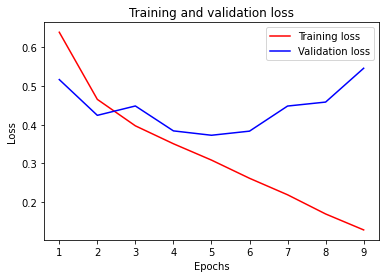

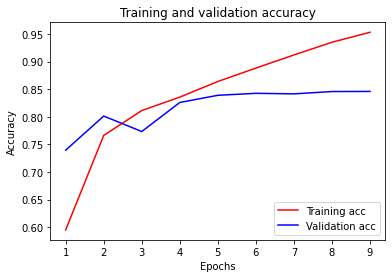

              precision    recall  f1-score   support

           0      0.819     0.883     0.850     12500
           1      0.873     0.805     0.838     12500

    accuracy                          0.844     25000
   macro avg      0.846     0.844     0.844     25000
weighted avg      0.846     0.844     0.844     25000


KFold: 7 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 149s 255ms/step - loss: 0.7195 - binary_accuracy: 0.5228 - val_loss: 0.5339 - val_binary_accuracy: 0.7104
Epoch 2/100
563/563 [==============================] - 143s 253ms/step - loss: 0.5029 - binary_accuracy: 0.7390 - val_loss: 0.4237 - val_binary_accuracy: 0.7928
Epoch 3/100
563/563 [==============================] - 143s 254ms/step - loss: 0.4012 - binary_accuracy: 0.8111 - val_loss: 0.4050 - val_binary_accuracy: 0.8216
Epoch 4/100
563/563 [==============================] - 143s 255ms/step - loss: 0.3434 - binary_accuracy: 0.8414 - val_loss: 0.3939 - val_binary_accuracy: 0.8232
Epoch 5/100
563/563 [==============================] - 143s 254ms/step - loss: 0.3087 - binary_accuracy: 0.8618 - val_loss: 0.3958 - val_binary_accuracy: 0.8374
Epoch 6/100
563/563 [==============================] - 143s 254ms/step - loss: 0.2623 - binary_accuracy

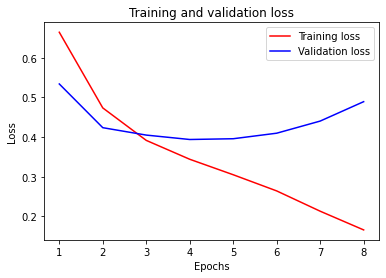

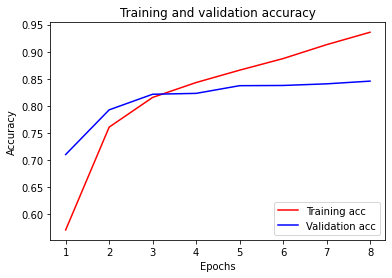

              precision    recall  f1-score   support

           0      0.781     0.910     0.841     12500
           1      0.892     0.745     0.812     12500

    accuracy                          0.828     25000
   macro avg      0.837     0.828     0.827     25000
weighted avg      0.837     0.828     0.827     25000


KFold: 8 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 150s 255ms/step - loss: 0.8336 - binary_accuracy: 0.5047 - val_loss: 0.5639 - val_binary_accuracy: 0.6864
Epoch 2/100
563/563 [==============================] - 143s 254ms/step - loss: 0.5376 - binary_accuracy: 0.7097 - val_loss: 0.4363 - val_binary_accuracy: 0.7970
Epoch 3/100
563/563 [==============================] - 143s 254ms/step - loss: 0.4139 - binary_accuracy: 0.7977 - val_loss: 0.3970 - val_binary_accuracy: 0.8104
Epoch 4/100
563/563 [==============================] - 144s 256ms/step - loss: 0.3575 - binary_accuracy: 0.8348 - val_loss: 0.4109 - val_binary_accuracy: 0.8106
Epoch 5/100
563/563 [==============================] - 143s 254ms/step - loss: 0.3142 - binary_accuracy: 0.8619 - val_loss: 0.4038 - val_binary_accuracy: 0.8344
Epoch 6/100
563/563 [==============================] - 143s 254ms/step - loss: 0.2655 - binary_accuracy

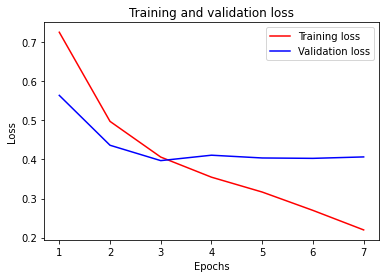

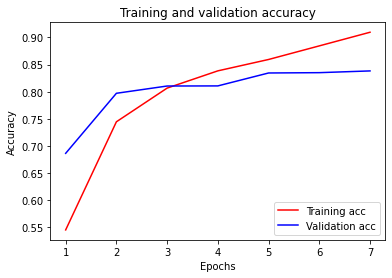

              precision    recall  f1-score   support

           0      0.788     0.883     0.833     12500
           1      0.867     0.762     0.812     12500

    accuracy                          0.823     25000
   macro avg      0.828     0.823     0.822     25000
weighted avg      0.828     0.823     0.822     25000


KFold: 9 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 150s 257ms/step - loss: 0.7100 - binary_accuracy: 0.5383 - val_loss: 0.5299 - val_binary_accuracy: 0.7232
Epoch 2/100
563/563 [==============================] - 144s 256ms/step - loss: 0.5048 - binary_accuracy: 0.7384 - val_loss: 0.4330 - val_binary_accuracy: 0.7998
Epoch 3/100
563/563 [==============================] - 144s 256ms/step - loss: 0.4110 - binary_accuracy: 0.8073 - val_loss: 0.4164 - val_binary_accuracy: 0.8198
Epoch 4/100
563/563 [==============================] - 144s 255ms/step - loss: 0.3456 - binary_accuracy: 0.8466 - val_loss: 0.3928 - val_binary_accuracy: 0.8280
Epoch 5/100
563/563 [==============================] - 144s 255ms/step - loss: 0.3047 - binary_accuracy: 0.8632 - val_loss: 0.3710 - val_binary_accuracy: 0.8298
Epoch 6/100
563/563 [==============================] - 144s 256ms/step - loss: 0.2665 - binary_accuracy

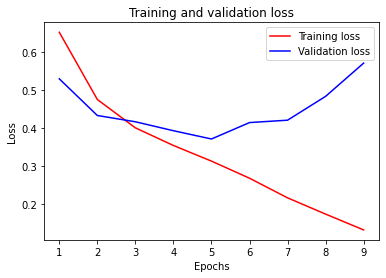

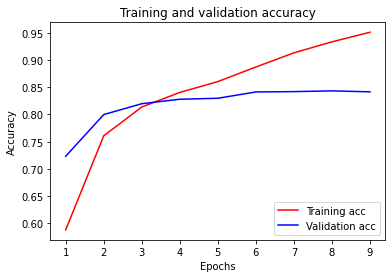

              precision    recall  f1-score   support

           0      0.817     0.889     0.852     12500
           1      0.879     0.801     0.838     12500

    accuracy                          0.845     25000
   macro avg      0.848     0.845     0.845     25000
weighted avg      0.848     0.845     0.845     25000


KFold: 10 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 149s 256ms/step - loss: 0.6926 - binary_accuracy: 0.5399 - val_loss: 0.5296 - val_binary_accuracy: 0.7364
Epoch 2/100
563/563 [==============================] - 144s 256ms/step - loss: 0.5109 - binary_accuracy: 0.7395 - val_loss: 0.4365 - val_binary_accuracy: 0.8022
Epoch 3/100
563/563 [==============================] - 143s 255ms/step - loss: 0.4055 - binary_accuracy: 0.8086 - val_loss: 0.4059 - val_binary_accuracy: 0.8044
Epoch 4/100
563/563 [==============================] - 143s 255ms/step - loss: 0.3559 - binary_accuracy: 0.8370 - val_loss: 0.3860 - val_binary_accuracy: 0.8236
Epoch 5/100
563/563 [==============================] - 144s 255ms/step - loss: 0.3222 - binary_accuracy: 0.8590 - val_loss: 0.3861 - val_binary_accuracy: 0.8336
Epoch 6/100
563/563 [==============================] - 142s 253ms/step - loss: 0.2584 - binary_accuracy

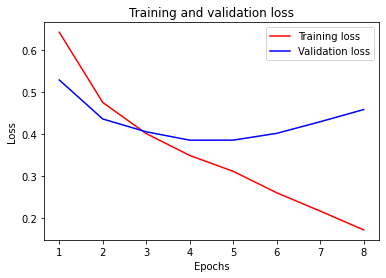

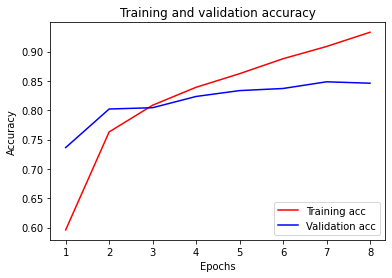

              precision    recall  f1-score   support

           0      0.801     0.894     0.845     12500
           1      0.880     0.777     0.826     12500

    accuracy                          0.836     25000
   macro avg      0.841     0.836     0.835     25000
weighted avg      0.841     0.836     0.835     25000


Average accuracy: 0.8390 (+/- 0.0077)
Average loss: 0.3589 (+/- 0.0097)
Average F1: 0.8310 (+/- 0.0109)


In [7]:
# Create and train the Model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
cv_acc = []
cv_loss = []
cv_f1 = []
n = 1

x_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

for train, valid in kfold.split(x_train, y_train):
  print("KFold: {} starts.".format(n))
  tf.keras.backend.clear_session()

  text_input = Input(shape=(), dtype=tf.string, name="text")
  preprocessing_layer = KerasLayer(handle=tfhub_handle_preprocess, name="preprocessing")
  encoder_inputs = preprocessing_layer(text_input)
  encoder = KerasLayer(handle=tfhub_handle_encoder, trainable=True, name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = Dropout(rate=0.1)(net)
  net = Dense(units=1, activation=None, name="classifier")(net)
  model = Model(inputs=text_input, outputs=net)
  # plot_model(model)

  steps_per_epoch = cardinality(train_ds).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1 * num_train_steps)

  optimizer = optimization.create_optimizer(init_lr=lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type="adamw")

  model.compile(
      optimizer=optimizer,
      loss=BinaryCrossentropy(from_logits=True),
      metrics=tf.metrics.BinaryAccuracy())

  print(f"Training model with {tfhub_handle_encoder}")
  history = model.fit(
      x=x_train[train],
      y=y_train[train],
      validation_data=val_ds,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback])
  
  loss, acc = model.evaluate(test_ds, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  y_test = np.concatenate([y for x, y in test_ds], axis=0)
  y_pred = (model.predict(test_ds) > 0.5).astype("int32")
  report = classification_report(y_true=y_test, y_pred=y_pred, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=y_test, y_pred=y_pred, average="binary")
  cv_f1.append(f1)

  print("")
  n += 1

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
